## Lecture 8 - Projective Transformations; Image Alignment 1

#### Announcements

* Week 2, woo!
  * New pairs:
    |  |  |
    |----|----|
    | Charlie | Finn   |
    | Shingo  | Camiel |
    | Jacob   | Grayson|
    | Ned     | Layla  |

* Homework for today: (all of and only) P08

* How's Project 1 going?
  * Questions about Laplacian pyramid construction and reconstruction?


#### Goals

* Know what kinds of transformations can be represented using linear and affine transformations.
* Know how to interpret homogeneous points with a third coordinate that is not 1.
  * Understand the meaning of homogeneous points at infinity.
* Know the definition of a projective transformation (homography), and gain some geometric intuition for what it represents in 2D.
* Know how to find a least-squares best-fit transformation for:
  * translation
  * affine

### Context: Panorama Stitching Overview

* [x] Detect features - Harris corners
* [x] Describe features - MOPS descriptor
* [x] Match features - SSD + ratio test
* Estimate motion model from correspondences
    * [ ] Translation
    * [ ] Affine
    * [ ] Projective
    * [ ] Robustness to outliers - RANSAC
* Warp image(s) into common coordinate system and blend
    * [ ] Inverse warping
    * [ ] Blending

In [3]:
# boilerplate setup
%load_ext autoreload
%autoreload 2

%matplotlib inline

import os
import sys

src_path = os.path.abspath("../src")
if (src_path not in sys.path):
    sys.path.insert(0, src_path)

# Library imports
import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt
import skimage as skim
import cv2

# codebase imports
import util
import filtering
import features
import geometry

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Plan

* What can we do with linear, rigid, and affine transformations?
  * Online demo https://iis.uibk.ac.at/public/piater/courses/demos/homography/homography.xhtml
  * **HW 1-3**
* Train tracks example
* We need something else. No messing with the third row. Mess with the third row!
* Homogeneous coordinates redux: normalization and equivalence.
* **HW 4**
* Homogeneous: interpretation in 2D
* Homogeneous interpretation in faux-3D
* **HW5-7** How many DOF does a homography have?
* Break, if not already
*  Solving for the best model given noisy correspondences: translations revisited
  * /shrug average
  * Linear algebra setup: minimize squared residuals
* Affine transformations: massaging into $Ax = b$ form

#### Panorama Stitching: Example Cases

<img src="../data/yos1.jpg" width="300"/><img src="../data/yos2.jpg" width="300"/>


<img src="../data/atrium1.png" width="300"/><img src="../data/atrium2.png" width="300"/>


**Question**: what geometric relationships can translations model? How about affine?

##### Homework Problems 1-2

Consider the following geometric properties. The first several questions ask which of them are preserved by a given class of geometric transformations. For each question, give a list of letters corresponding to which properties are preserved (i.e., left unchanged) by the given class of geometric transformations.

**Note:** Feel free to use [this online demo](https://iis.uibk.ac.at/public/piater/courses/demos/homography/homography.xhtml) to gain intuition and try things out as you work through these, keeping in mind that affine transformations are only those where the last row remains $\begin{bmatrix}0 & 0 & 1\end{bmatrix}$. 

1. Which are preserved under translation?
2. Which are preserved under affine transformations?

A. Line straightness

B. Line lengths

C. Ratios of lengths along a line

D. Parallelism of lines

E. Angles

F. Locations of points

G. Location of the origin

**Claim:** Affine translations *can't* model a typical panorama sequence well beyond a certain field of view.

**Justification:** Let's talk about train tracks.

![](../data/tracks1.png)

What would you see if you changed your view angle to point straight down towards the tracks?

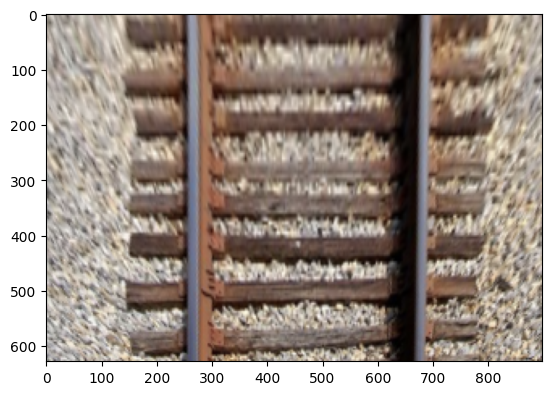

In [4]:
plt.imshow(imageio.imread("../data/tracks2.png"))

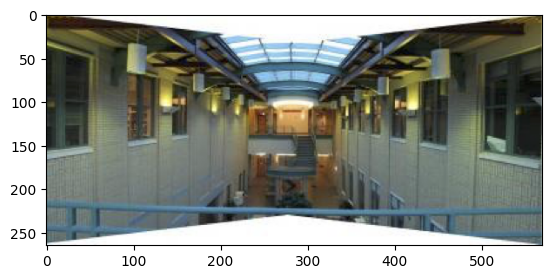

In [5]:
plt.imshow(imageio.imread("../data/atrium3.png"))

**Implication**: we need a new, more general class of geometric transformations.

Scott: don't mess with the third row!

You: what if we mess with the third row?

Scott: Well, okay. You asked. [Let's try it!](https://iis.uibk.ac.at/public/piater/courses/demos/homography/homography.xhtml)

Whiteboard: what does the third coordinate mean?
* These 3-vectors represent 2D points. Each point now has an equivalence class of 3-vectors equivalent up to scale.
* 2D interpretation - points can move around on a plane but project back to a line
* 3D interpretation - points can move around in 3-space but project back to a plane.

How many **Degrees of Freedom** does each of these transformations have?
* Translation?
* Affine?
* Projective (aka Homography?)


##### Homework Problems 4-5

In the next two problems, we'll show that a homography has only 8 degrees of freedom. In other words, for any homography $H$ that is not all zeros, there is a homography $H' = H / h_{33}$​ that has the same effect on homogeneous coordinates.

4. Let  $
   H = \begin{bmatrix}
   a & b & c \\
   d & e & f \\
   g & h & k \\
   \end{bmatrix}$ and $\mathbf{x} = \begin{bmatrix}x\\ y \\ 1\end{bmatrix}$. Compute  $H\mathbf{x}$​ and normalize the resulting homogeneous point.
5. Compute $\frac{1}{k}H\mathbf{x}$ and normalize the resulting homogeneous point.

### Context: Panorama Stitching Overview

* [x] Detect features - Harris corners
* [x] Describe features - MOPS descriptor
* [x] Match features - SSD + ratio test
* Estimate motion model from correspondences (**next up!**)
    * [ ] Translation (we hand-waved this)
    * [ ] Affine
    * [ ] Projective
        * [x] **We now have new math for this!**
    * [ ] Robustness to outliers - RANSAC
* Warp image(s) into common coordinate system and blend
    * [ ] Inverse warping (so far we've used `geometry.warp`)
    * [ ] Blending

We know how to model a geometric transformation. How do we **fit** that model given correspondences?

Basic version: Depends on **Degrees of Freedom**!
* Translation - 2 DOF, requires 1 pair of corresponding points
* Affine - 6 DOF, requires 3 pairs of corresponding points
* Projective (aka Homography) - 8 DOF, requires 4 pairs of corresponding points.

But usually we'll have more than that, and they won't all agree. We hand-waved the translation case by saying "let's average them, that seems sensible!" but it's not as clear what's sensible for fitting affine and projective.


#### Problem Statement

Given a set of (**imperfect**) feature matches, how do I find the *optimal* transformation that relates the two images?


What's optimal? Our definition: minimize the sum of squared residuals:
$$
\min_T \sum_i||(T\mathbf{p}_i - \mathbf{p}_i')||^2
$$

Our optimistic hope (which will be mostly substantiated): this ends up being linear and can be solved with **linear least squares**.

In other words, we're looking to turn the minimization of the sum of squared residuals  $$
  \min_T \sum_i||(T\mathbf{p}_i - \mathbf{p}_i')^2||
  $$
   into a minimization of a linear least squares system
  $$
  \min_\mathbf{x} ||A\mathbf{x} - \mathbf{b}||
  $$

Solution approach for all three models (translation, affine, projective):
1. Write down the residuals.
2. Massage into $||A\mathbf{x} - \mathbf{b}||$ form.
3. Solve